In [3]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import numpy as np

from HPA_CC.utils.pseudotime import intensities_to_pseudotime
from HPA_CC.utils.pseudotime import stretch_time
from HPA_CC.data.dataset import intensity_name, pseudotime_label_name
from HPA_CC.utils.gmmot import GW2, GW2_map

import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import ot
import ot.plot

hpa_cc_datafile = Path('ProteinPseudotimePlotting.tsv')

In [4]:
hpa_cc_df = pd.read_csv(hpa_cc_datafile, sep='\t')
hpa_cc_df.head()

,ENSG,Antibody,Compartment,CCD,cell_pseudotime,cell_intensity,cell_fred,cell_fgreen,mvavg_x,mvavg_y,mvavgs_10p,mvavgs_90p,mvavgs_25p,mvavgs_75p,phase,gini,percent_variance,WellPlate
0,ENSG00000158321,HPA000390,Nuc,Pseudotime,"0.985,0.98,0.958,0.956,0.939,0.918,0.906,0.886...","0.7390379271165064,0.26638857293726376,0.23516...","-0.3367071628231325,-0.2537370752453728,-0.327...","0.16949821761323114,0.15437852625202098,0.2811...","0.9273,0.9158999999999999,0.9047000000000001,0...","0.5159648053986967,0.4660035371680031,0.466981...","0.23422860850573798,0.23422860850573798,0.2342...","0.7100372240546419,0.6975376607329703,0.697537...","0.27670764279798576,0.24616607684149372,0.2486...","0.6955110140225208,0.6840873393518287,0.684087...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.259460,0.075247,A01_55185977
1,ENSG00000136108,HPA008410,Cell,No,"0.999,0.999,0.999,0.999,0.998,0.997,0.996,0.99...","0.51376959183985,0.7405869142211623,0.81868294...","-0.3725437022652657,-0.6231683707284121,-0.549...","-0.23242950472018076,-0.31747863894368267,-0.1...","0.9970000000000001,0.9964000000000002,0.9956,0...","0.6817120990446968,0.6867546091391149,0.679389...","0.4806172070165337,0.5259997978662968,0.525999...","0.9654769367216557,0.9654769367216557,0.965476...","0.5686379490285043,0.5686379490285043,0.568637...","0.8439480208343555,0.8439480208343555,0.843948...","G1,G1,G1,G1,G1,G1,G1,G1,G2,G1,G1,G1,G1,G1,G1,G...",0.263932,0.162583,A01_55195978
2,ENSG00000138347,HPA036299,Nuc,No,"0.994,0.988,0.987,0.983,0.983,0.983,0.981,0.97...","0.4375524453497077,0.379598311989224,0.4250342...","-0.6154224138635805,-0.5262924859426088,-0.561...","0.13745277197115247,0.2372470014436192,0.26784...","0.9833,0.9809,0.9788,0.9768,0.9749000000000001...","0.4582648704273652,0.47214338563201247,0.47211...","0.3781681674751873,0.3781681674751873,0.377899...","0.5849546992393218,0.5883825809816025,0.588382...","0.39167250785765256,0.39167250785765256,0.3916...","0.4577311068262303,0.545106306371072,0.5451063...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.128947,0.169056,A01_55215982
3,ENSG00000111605,HPA039973,Nuc,No,"0.996,0.99,0.977,0.976,0.976,0.975,0.97,0.97,0...","0.8101348993256068,0.6795541246218457,0.522480...","-0.3639438962224717,-0.5128467733879262,-0.568...","0.01976830044182032,0.1974365965385232,0.36987...","0.9764,0.9727,0.9694,0.9672000000000001,0.9646...","0.6465866833930525,0.6238660102519809,0.603861...","0.5282544974850903,0.5282544974850903,0.518182...","0.7934222794495805,0.7166186783702061,0.716618...","0.5606609988735599,0.5605516964028059,0.534945...","0.7011069863235018,0.6724617441088006,0.647713...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.091280,0.109277,A01_55225983
4,ENSG00000106012,HPA019515,Nuc,Pseudotime,"0.989,0.984,0.982,0.978,0.971,0.967,0.952,0.94...","0.5969635594559007,0.5025506437395802,0.051360...","-0.4479913643858908,-0.413693784511982,-0.2077...","0.18321627760853776,0.21965267249632658,0.1187...","0.9633999999999999,0.9565,0.9501000000000001,0...","0.5187417333868999,0.5001823582743513,0.523089...","0.38392780352238387,0.37536885280545856,0.3753...","0.6456019456179166,0.6456019456179166,0.742913...","0.4878897119154546,0.4367612392326159,0.436761...","0.6087973121769674,0.5975933084128137,0.620809...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.182334,0.560001,A01_55235979


In [5]:
def clean_ints(int_list):
    return [float(x) for x in int_list.split(',')]
gmnn, cdt1 = [], []
for i, row in hpa_cc_df.iterrows():
    gmnn.extend(clean_ints(row['cell_fgreen']))
    cdt1.extend(clean_ints(row['cell_fred']))
log_intensities = np.stack([gmnn, cdt1], axis=1)
print(log_intensities.shape)

(254716, 2)


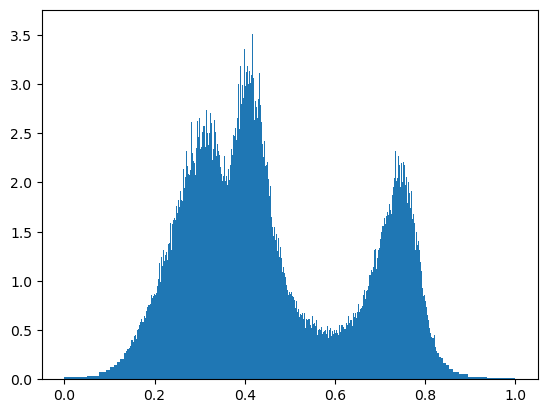

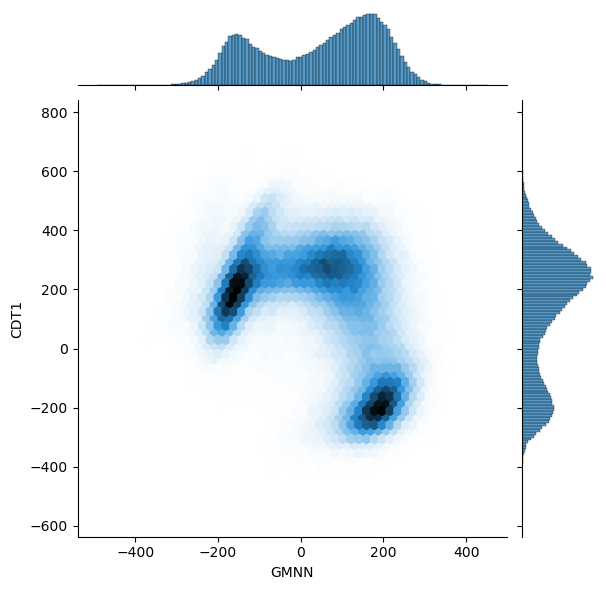

In [6]:
fucci_time, raw_time, centered_rescaled_intensities = intensities_to_pseudotime(log_intensities, rescale=True, auto_start=True)
sns.jointplot(x='GMNN', y='CDT1', data=pd.DataFrame(centered_rescaled_intensities, columns=['GMNN', 'CDT1']), kind='hex')

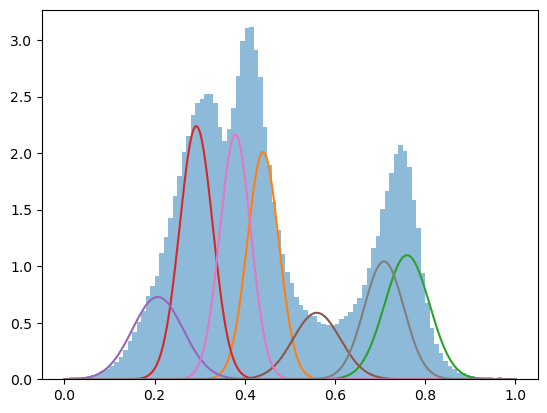

In [7]:
from sklearn.mixture import GaussianMixture

gmm_hpa = GaussianMixture(n_components=7)
gmm_hpa.fit(raw_time.reshape(-1, 1))

plt.hist(raw_time, density=True, alpha=0.5, bins=100)

# Plot the GMM components
x = np.linspace(0, 1, 1000)
y = np.exp(gmm_hpa._estimate_weighted_log_prob(x.reshape(-1, 1)))
for i in range(gmm_hpa.n_components):
    plt.plot(x, y[:, i], label=f'Component {i}')


# Optimal Transport of Imaging-based angles to FACS-based

In [8]:
from HPA_CC.data.dataset import load_labels
from config import FUCCI_DS_PATH
angle_labels = load_labels("angle", FUCCI_DS_PATH, "minimal")
phase_labels = np.argmax(load_labels("phase", FUCCI_DS_PATH, "minimal", scope=True), axis=1)

Loading /data/ishang/FUCCI-dataset-well/minimal_sample_angles.pt
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt


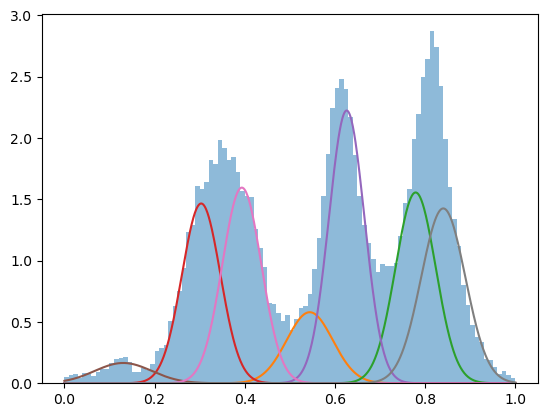

In [9]:
gmm_fucci = GaussianMixture(n_components=7)
gmm_fucci.fit(angle_labels.reshape(-1, 1))

plt.hist(angle_labels, density=True, alpha=0.5, bins=100)

# Plot the GMM components
x = np.linspace(0, 1, 1000)
y = np.exp(gmm_fucci._estimate_weighted_log_prob(x.reshape(-1, 1)))
for i in range(gmm_fucci.n_components):
    plt.plot(x, y[:, i], label=f'Component {i}')

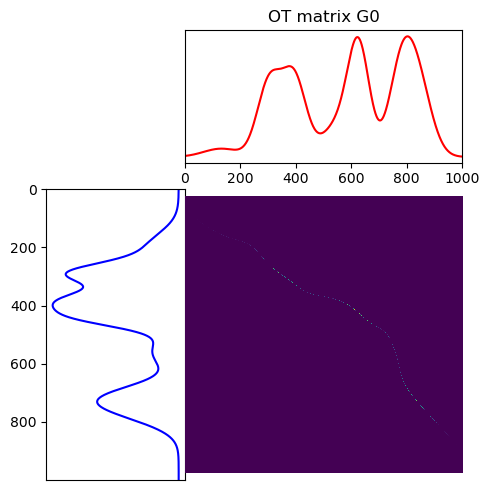

In [10]:
pi_hpa, mu_hpa, sigma_hpa = gmm_hpa.weights_, gmm_hpa.means_, gmm_hpa.covariances_
pi_fucci, mu_fucci, sigma_fucci = gmm_fucci.weights_, gmm_fucci.means_, gmm_fucci.covariances_
n = 1000
x = np.linspace(0, 1, n)
gmm0 = np.sum(np.exp(gmm_hpa._estimate_weighted_log_prob(x.reshape(-1, 1))), axis=1)
gmm0 = gmm0 / gmm0.sum()
gmm1 = np.sum(np.exp(gmm_fucci._estimate_weighted_log_prob(x.reshape(-1, 1))), axis=1)
gmm1 = gmm1 / gmm1.sum()
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1))) # initializing matrix M
M /= M.max()
G0 = ot.emd(gmm0, gmm1, M)
plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(gmm0, gmm1, G0, 'OT matrix G0') # gmm* are the marginals, G0 is the optimal transport matrix

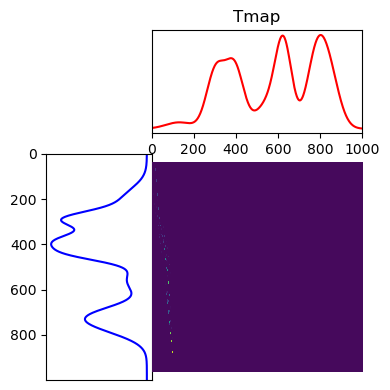

In [11]:
wstar, dist = GW2(pi_hpa, pi_fucci, mu_hpa, mu_fucci, sigma_hpa, sigma_fucci)
Tmap, Tmean = GW2_map(pi_hpa, pi_fucci, mu_hpa, mu_fucci, sigma_hpa, sigma_fucci, wstar, x.reshape(n, 1))
plt.figure(3, figsize=(4, 4))
ot.plot.plot1D_mat(gmm0, gmm1, Tmap, 'Tmap')

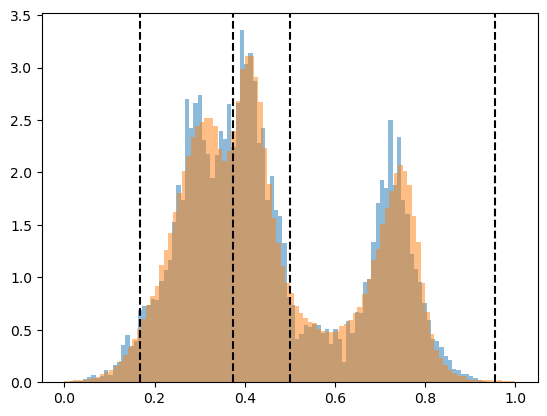

In [12]:
# Bin the FUCCI angle data
bins = np.linspace(0, 1, n)  # Define the bin edges
fucci_binned_angles = np.digitize(angle_labels, bins) - 1  # Bin the angles
one_hot_fucci = np.zeros((len(fucci_binned_angles), n))
one_hot_fucci[np.arange(len(fucci_binned_angles)), fucci_binned_angles] = 1
one_hot_fucci_in_hpa = np.dot(G0, one_hot_fucci.T).T
# one_hot_fucci_in_hpa = np.dot(Tmean, one_hot_fucci.T).T
fucci_in_hpa_binned = np.argmax(one_hot_fucci_in_hpa, axis=1)
fucci_in_hpa = bins[fucci_in_hpa_binned]
plt.hist(fucci_in_hpa, bins=100, alpha=0.5, label='FUCCI', density=True)
plt.hist(raw_time, bins=100, alpha=0.5, label='HPA', density=True)
class_cutoffs = [np.max(fucci_in_hpa[phase_labels == i]) for i in sorted(np.unique(phase_labels))]
for cutoff in class_cutoffs:
    plt.axvline(cutoff, color='k', linestyle='--')
plt.show()

<Axes: xlabel='Pseudotime', ylabel='CDT1'>

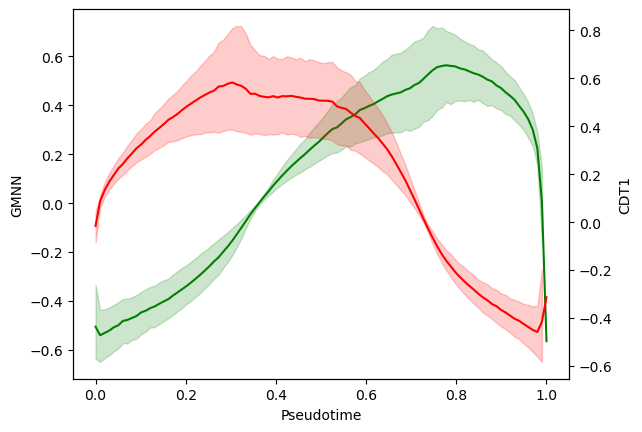

In [13]:
bins = np.linspace(0, 1, 100)  # Define the bin edges
binned_hpa_time = np.digitize(fucci_time, bins) - 1
hpa_time = bins[binned_hpa_time]
hpa_marker_df = pd.DataFrame({"Pseudotime": hpa_time, "GMNN": gmnn, "CDT1": cdt1})
ax = sns.lineplot(x='Pseudotime', y='GMNN', data=hpa_marker_df, label='GMNN', color='g', errorbar=('pi', 75), legend=False)
ax2 = ax.twinx()
sns.lineplot(x='Pseudotime', y='CDT1', data=hpa_marker_df, label='CDT1', ax=ax2, color='r', errorbar=('pi', 75), legend=False)

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


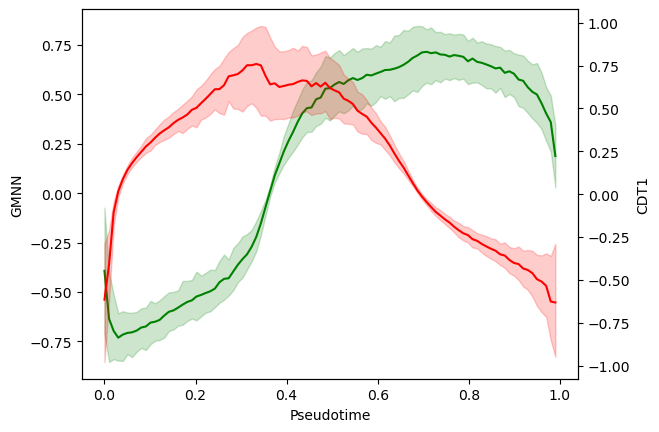

In [14]:
data_dir, data_name = Path('/data/ishang/FUCCI-dataset-well'), "minimal"
well_std_intensities = np.load(intensity_name(data_dir, data_name))
fucci_time_stretched = stretch_time(fucci_in_hpa)
binned_fucci_time = np.digitize(fucci_time_stretched, bins) - 1
fucci_u2os_time = bins[binned_fucci_time]
fucci_gmnn, fucci_cdt1 = well_std_intensities[:, 0], well_std_intensities[:, 1]
fucci_marker_df = pd.DataFrame({"Pseudotime": fucci_u2os_time, "GMNN": fucci_gmnn, "CDT1": fucci_cdt1})
plt.clf()
ax = sns.lineplot(x='Pseudotime', y='GMNN', data=fucci_marker_df, label='GMNN', color='g', errorbar=('pi', 75), legend=False)
ax2 = ax.twinx()
sns.lineplot(x='Pseudotime', y='CDT1', data=fucci_marker_df, label='CDT1', ax=ax2, color='r', errorbar=('pi', 75), legend=False)
plt.show()

In [23]:
from HPA_CC.models.train import find_checkpoint_file, PseudoRegressorLit
from HPA_CC.data.dataset import RefCLSDM
from HPA_CC.models.utils import regressor_inference
log_dirs_home = Path("/data/ishang/pseudotime_pred/")
split = (0.64, 0.16, 0.2)
data_dir = Path("/data/ishang/FUCCI-dataset-well")
data_name = "minimal"
device = "cuda:0"
model_name = "HPA DINO Pseudotime Regressor"
model_hash = "81peszw2"
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = False # were intensity statistics added to the embedding? (not used from conv)
label_type = "pseudotime" # "phase", "angle", or "pseudotime"
scope = None
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
pseudo_model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
pseudo_model.to(device)
pseudo_model.eval()
pseudo_dataset = RefCLSDM(data_dir, data_name, 32, 1, split, (repr_type == "hpa_dino"), label_type, scope, int_stats)
pseudotime_preds = regressor_inference(pseudo_model, pseudo_dataset.shared_dataloader(pseudo_dataset.dataset), device)

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_pseudotime.pt
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
X shape: torch.Size([31732, 1536])
Y shape: torch.Size([31732])


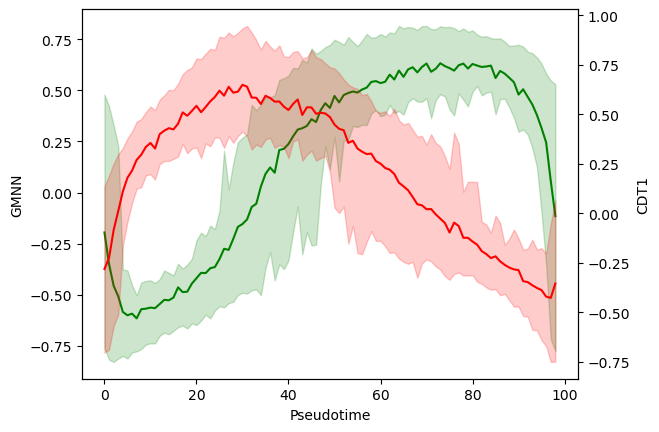

In [31]:
stretched_pseudotime_preds = stretch_time(pseudotime_preds)
# stretched_pseudotime_preds = pseudotime_preds
binned_pseudotime_preds = np.digitize(stretched_pseudotime_preds, bins) - 1
pred_fucci_marker_df = pd.DataFrame({"Pseudotime": binned_pseudotime_preds, "GMNN": fucci_gmnn, "CDT1": fucci_cdt1})
plt.clf()
ax = sns.lineplot(x='Pseudotime', y='GMNN', data=pred_fucci_marker_df, label='GMNN', color='g', errorbar=('pi', 75), legend=False)
ax2 = ax.twinx()
sns.lineplot(x='Pseudotime', y='CDT1', data=pred_fucci_marker_df, label='CDT1', ax=ax2, color='r', errorbar=('pi', 75), legend=False)
plt.show()

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


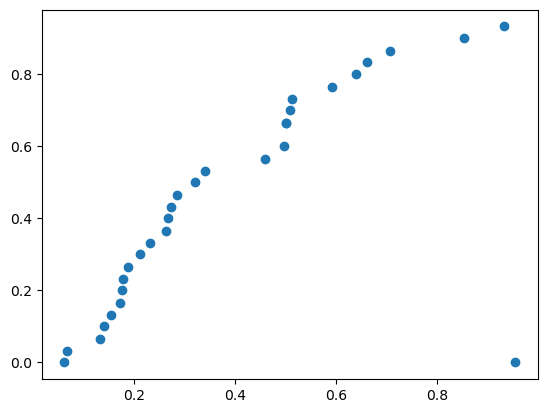

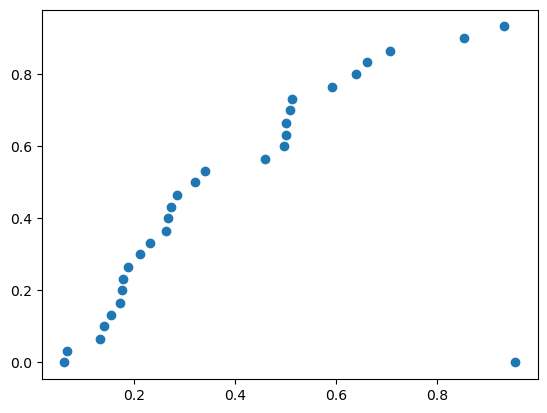

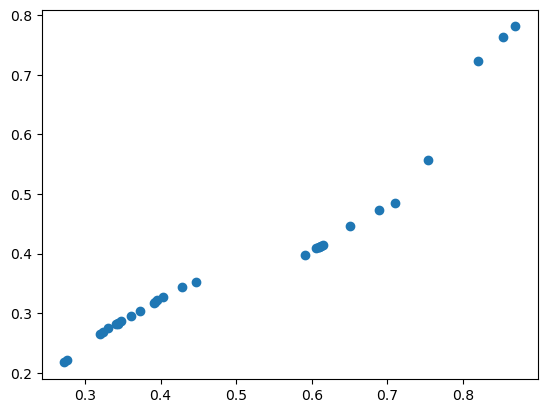

In [16]:
import torch
from HPA_CC.data.dataset import pseudotime_label_name
random_idx = np.random.choice(len(fucci_in_hpa), 30)
fucci_in_hpa_time_stretched_sample = stretch_time(fucci_in_hpa[random_idx])
fucci_time_stretched_sample = stretch_time(angle_labels[random_idx])
plt.clf()
plt.scatter(fucci_time_stretched[random_idx], fucci_in_hpa_time_stretched_sample)
plt.show()
plt.clf()
plt.scatter(fucci_time_stretched[random_idx], fucci_time_stretched_sample)
plt.show()
plt.clf()
plt.scatter(angle_labels[random_idx], fucci_in_hpa[random_idx])
plt.show()